# Tutorial for *BiLO: Bi-Level Local Operator for PDE inverse problem. Part II: Efficient Bayesian Inverse Problem with Low Rank Adaptation*

## PDE Bayesian Inverse Problem

Consider a PDE that depends on some parameter $\theta$:
$$
\quad F(D^ku,\cdots, Du, u, \theta) = 0
$$

Given some observational data that depends on the solution $u$, and the prior $P(\theta)$, we aim to find the posterior distribution $P(\theta|\rm{Data})$, which is given by Bayes' theorem:
$$
P(\theta|\rm{Data}) \propto P(\rm{Data}|\theta)P(\theta)
$$


The potential energy function is defined as:
$$
U(\theta) = -\log P(\rm{Data}|\theta) - \log P(\theta)
$$

The potential energy function $U(\theta) = U[u(\cdot,\theta)]$ is a functional on the PDE solution $u(\cdot,\theta)$.
To sample the posterior distribution using gradient-based Markov Chain Monte-Carlo (MCMC) methods, such as Hamiltonian Monte Carlo (HMC), we need to compute the gradient of the potential energy function with respect to $\theta$.

## Bi-Level local Operator Learning (BiLO) for PDE Bayesian Inverse Problem

We solve the following bi-level problem
$$\begin{aligned}
& \theta \sim \exp\{-U[u(\cdot,\theta;W^*(\theta))]\} \\
&W^*(\theta) = \arg\min_{W} \quad \|F(u(\cdot,\theta;W),\theta)\|^2 + \|d_\theta F(u(\cdot,\theta;W),\theta)\|^2 \\
\end{aligned}$$

At the upper level, we sample $\theta$ from the posterior distribution using gradient-based MCMC. At the lower level, for each $\theta$, we minimize the residual loss and the residual-gradient loss with respect to the network weights $W$.

## Example


In this example, we solve the following PDE inverse problem in a Bayesian framework. The PDE is given by:

$$
D u'' = f, \quad u(0) = 0, \quad u(1) = 0
$$

where $f = - \pi^2 \sin(\pi x)$. D is an unknown PDE parameter. In this example, $\theta = \{D\}$, and the full solution operator is $u(x,D) = \sin(\pi x)/D$. 


We will generate our synthetic data using a known ground-truth parameter, $D_{gt}$. 

We observe the data $\hat{u}_i = u(x_i, D_{gt}) + \epsilon_i$ at $N$ points $x_i \in [0,1]$, where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ is Gaussian noise. The likelihood is given by:

$$
  P(Data|D) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\frac{1}{2\sigma^2} \left| u(x_i,D) - \hat{u}_i\right|^2 \right)
$$

The prior distribution for $D$, $P(D)$, is [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) with shape parameter $\alpha=2$ and rate parameter $\lambda=1$.

In [1]:
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# For this tutorial, we need to install the LoRA library.
import loralib as lora

# set seed
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class DenseNet(nn.Module):
    '''General class for a dense neural network with a variable number of layers and width.'''
    def __init__(self, depth=4, width=64, rank=0,
                 output_transform=lambda x, u: u):
        super(DenseNet, self).__init__()
        input_dim = 1
        output_dim = 1
        self.width = width
        self.depth = depth
        self.activation = torch.tanh
        layers = []

        # input layer/embedding layer
        self.input_layer = lora.Linear(input_dim, width, r=rank)

        # hidden layers (depth - 2)
        self.hidden_layers = nn.ModuleList([lora.Linear(width, width, r=rank) for _ in range(depth - 2)])
        self.output_layer = lora.Linear(width, output_dim, r=rank)

        # Store the output transformation function
        self.output_transform = output_transform
    

    def forward(self, x):
        # Define the forward pass
        act = self.activation
        u = act(self.input_layer(x))
        for layer in self.hidden_layers:
            u = act(layer(u))
        u = self.output_layer(u)
        
        return self.output_transform(x, u)


In [3]:
def prior(x):
    '''
    Prior distribution P(x).
    Gamma distribution with shape alpha and rate lambda. Following wikipedia notation.
    '''
    alpha = 2 # shape
    lmbd = 1 # rate
    prior = (lmbd**alpha / torch.exp(torch.lgamma(torch.tensor(alpha)))) * (x**(alpha - 1)) * torch.exp(-lmbd * x)
    return prior

In [4]:
class ScalarPoisson():
    ''' 
    Class for the scalar Poisson equation D u_xx = f(x) on the domain [0, 1] with Dirichlet boundary conditions.
    '''
    def __init__(self, D = 1.0, sigma = 0.1):
        self.D = D
        self.sigma = sigma
        self.dataset = {}
    
    def f(self, x):
        ''' Forcing term'''
        return -(torch.pi)**2 * torch.sin(torch.pi * x)

    def u_exact(self, x, D):
        ''' Exact PDE solution for given D '''
        return torch.sin(torch.pi * x) / D
    
    def get_dataset(self, D0, N_res_train, N_dat_train, N_res_test, N_dat_test, nz_std = None):
        ''' Generate data and collocations points for training.'''
        
        self.D0 = torch.tensor(D0, dtype=torch.float32)
        self.dataset['D0'] = self.D0
        self.dataset['D'] = torch.tensor(self.D, dtype=torch.float32)

        self.N_res_train = N_res_train
        self.N_dat_train = N_dat_train
        self.N_res_test = N_res_test
        self.N_dat_test = N_dat_test

        # Collocation points for residual loss
        self.dataset['x_res_train'] = torch.linspace(0, 1, N_res_train).view(-1, 1)
        self.dataset['x_res_test'] = torch.linspace(0, 1, N_res_test).view(-1, 1)

        # Collocation points for data loss
        self.dataset['x_dat_test'] = torch.linspace(0, 1, N_dat_test).view(-1, 1)
        self.dataset['x_dat_train'] = torch.linspace(0, 1, N_dat_train).view(-1, 1)
        
        # use exact D for testing
        self.dataset['ugt_dat_test'] = self.u_exact(self.dataset['x_dat_test'], self.D)

        # use D0 for pre-training
        self.dataset['u0_dat_train'] = self.u_exact(self.dataset['x_dat_train'], self.D0)

        # u at ground truth D
        u = self.u_exact(self.dataset['x_dat_train'], self.D)

        # add noise to the data if nz_std is not None
        if nz_std is None:
            noise = 0
        else:
            noise = torch.randn_like(u) * nz_std
        
        # (noisy) data for bayesian inference
        self.dataset['u_dat_train'] = u + noise
    
    def to_device(self, device):
        # move all data to device
        for key in self.dataset:
            self.dataset[key] = self.dataset[key].to(device)

In [5]:
n_res_train = 11
n_dat_train = 11
n_res_test = 101
n_dat_test = 101
nz_std = 0.2
D_gt = 1.0 # ground truth D
D0 = 2.0 # initial guess for D
pde = ScalarPoisson(D=D_gt, sigma=nz_std)
pde.get_dataset(D0, n_res_train, n_dat_train, n_res_test, n_dat_test, nz_std=nz_std)


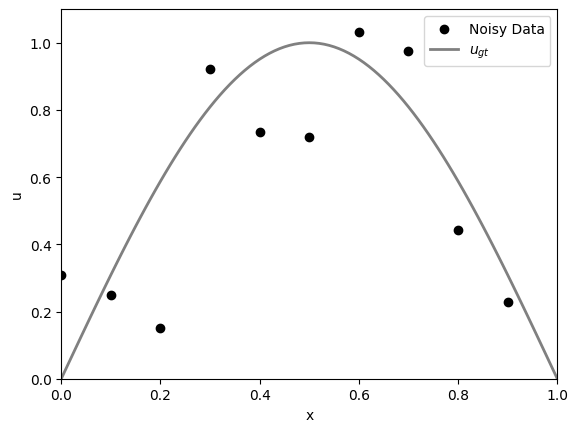

In [6]:
# Visualize the data
plt.scatter(pde.dataset['x_dat_train'], pde.dataset['u_dat_train'], label='Noisy Data', color='black')
plt.plot(pde.dataset['x_dat_test'], pde.u_exact(pde.dataset['x_dat_test'], D_gt), label='$u_{gt}$', color='gray', linewidth=2)
plt.xlabel('x')
plt.ylabel('u')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.legend()

In [7]:
class LocalOperator(DenseNet):
    '''Represent u(x, D; W), where W is the neural network weights.'''
    def __init__(self, fdepth=4, fwidth=64, rank=0,
                 output_transform=lambda x, u: u):
        super().__init__(fdepth, fwidth, rank, output_transform)

        # embedding layer
        self.param_embeddings = nn.Linear(1, self.width, bias=True)
        

    def embedding(self, x, z):
        '''
        Embedding layer for the coordinate x and PDE parameter z.
        This layer compute y = Wx + b + Rz, where R is a fixed embedding matrix.
        '''
        y = self.input_layer(x) 

        # expand the parameter to the same size as x
        self.params_expand = z.expand(x.shape[0], -1)
        param_embedding = self.param_embeddings(self.params_expand)
        y += param_embedding
        return y

    def forward(self, x , z):
        '''
        Forward pass of the network.
        '''
        X = self.embedding(x, z)
        X = self.activation(X)
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        u = self.output_layer(X)
        
        return self.output_transform(x, u)

In [8]:
class Bilo(nn.Module):
    '''
    A module that encapsulates the BiLO framework, including the local operator, PDE parameter, and loss functions.
    '''
    def __init__(self, localOp, pde):
        super(Bilo, self).__init__()
        
        self.localOp = localOp
        self.pde = pde
        self.dataset = pde.dataset

        # initial D
        D0 = pde.dataset['D0']

        # initialize D as a learnable parameter
        self.D = nn.Parameter(torch.tensor([[D0]]), requires_grad=True)

        self.param_weights = []  # collection of non-LoRA network weights (W)
        self.param_lora = [] # collection of LoRA parameters
        
        # collection of network weights, separate LoRA and non-LoRA parameters
        for layer in [self.localOp.input_layer] + list(self.localOp.hidden_layers) + [self.localOp.output_layer]:
            # Check if this is a LoRA-enhanced linear layer
            if isinstance(layer, lora.Linear):
                # Separate LoRA and non-LoRA parameters by name
                for name, param in layer.named_parameters():
                    if 'lora' in name.lower():
                        self.param_lora.append(param)
                    else:
                        self.param_weights.append(param)
            else:
                # Normal layer, add all parameters
                self.param_weights.extend(list(layer.parameters()))

        # collection of PDE parameters (theta)
        self.param_pde = [self.D]
        
        # weight for residual-gradient loss
        self.wresgrad = 0.1


    def train_base_weights(self):
        '''
        Full model fine-tuning.
        '''
        for param in self.param_lora:
            param.requires_grad = False
        for param in self.param_weights:
            param.requires_grad = True
        self.param_net = self.param_weights
        self.optimizer_lower = torch.optim.Adam(self.param_net, lr=1e-3)
    
    def train_lora(self):
        '''
        LoRA fine-tuning.
        '''
        for param in self.param_weights:
            param.requires_grad = False
        for param in self.param_lora:
            param.requires_grad = True
        self.param_net = self.param_lora
        self.optimizer_lower = torch.optim.Adam(self.param_net, lr=1e-3)

    def residual_grad_loss(self):
        ''' compute residual loss and residual-gradient loss'''
        x = self.dataset['x_res_train']
        x.requires_grad = True
        u = self.localOp(x, self.D)

        # compute the PDE residual
        u_x = torch.autograd.grad(u, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_xx = torch.autograd.grad(u_x, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u_x))[0]
        res = self.localOp.params_expand * u_xx - self.pde.f(x)

        # compute the gradient of the residual with respect to the parameters
        resgrad = torch.autograd.grad(res, self.localOp.params_expand, grad_outputs=torch.ones_like(res),
        create_graph=True, allow_unused=True)[0]
        
        # compute the loss
        res_loss = torch.mean(res**2)
        res_grad_loss = torch.mean(resgrad**2)
        
        return  res_loss, res_grad_loss
    
    def pretrain_data_loss(self):
        ''' 
        Compute the data loss for pretraining, 
        This loss speed up pre-training but is optional. 
        '''
        x = self.dataset['x_dat_train']
        u = self.localOp(x, self.D)
        u_dat = self.dataset['u0_dat_train']

        loss = torch.mean((u - u_dat)**2)
        return loss

    def potential_energy(self):
        ''' Potential energy '''
        x  = self.dataset['x_dat_train']
        u  = self.localOp(x, self.D)
        sigma = self.pde.sigma
        u_dat = self.dataset['u_dat_train']
        # negative log likelihood
        U = torch.sum((u - u_dat)**2)/ (2 * sigma**2)
        # negative log prior
        log_prior = -torch.log(prior(self.D))

        return U

    def pretrain(self, max_iter):
        '''
        Fix the D and pretrain the local operator for max_iter steps.
        '''
        optimizer = torch.optim.Adam(self.localOp.parameters(), lr=1e-3)
        for step in range(max_iter):
            optimizer.zero_grad()
            res_loss, resgrad_loss = self.residual_grad_loss()
            # data_loss = self.pretrain_data_loss()
            total_loss = res_loss + self.wresgrad * resgrad_loss
            total_loss.backward()
            optimizer.step()
            if step % 100 == 0:
                print(f'Step {step}, res_loss: {res_loss.item():.3e}, resgrad_loss: {resgrad_loss.item():.3e}, D: {self.D.item():.3f}')

    def lower_level_loop(self, D, tol_lower = 1e-4):  
        '''
        Solve lower level optimization problem for the network weights given D.
        '''
        with torch.no_grad():
            self.D.copy_(D)

        net_loss = float('inf')
        step = 0
        while net_loss > tol_lower and step < 1000:

            res_loss, resgrad_loss = self.residual_grad_loss()
            
            net_loss = res_loss + resgrad_loss * self.wresgrad

            grads_net = torch.autograd.grad(net_loss, self.param_net)
            for i, param in enumerate(self.param_net):
                param.grad = grads_net[i]
            
            self.optimizer_lower.step()
            step += 1
            # print(f'      lower {step}, net_loss: {net_loss.item():.3e}, res_loss: {res_loss.item():.3e}, resgrad_loss: {resgrad_loss.item():.3e}, D: {self.D.item():.3f}')

## Pre-training (Initialization)

In the pre-training step, we start with an initial guess, $D_0$, and pre-train the neural network weights (W) of the local operator $u(x, D; W)$ while keeping $D$ fixed at $D_0$.

In [9]:
localop = LocalOperator(rank=2, output_transform=lambda x, u: u * (1 - x)*x)
bilo = Bilo(localop, pde)
pde.to_device(device)
bilo.to(device)
max_iter = 1000
bilo.train_base_weights()
bilo.pretrain(max_iter)

Step 0, res_loss: 4.682e+01, resgrad_loss: 2.686e-02, D: 2.000
Step 100, res_loss: 1.153e-01, resgrad_loss: 3.206e+00, D: 2.000
Step 200, res_loss: 4.347e-03, resgrad_loss: 4.727e-02, D: 2.000
Step 300, res_loss: 6.082e-04, resgrad_loss: 1.356e-02, D: 2.000
Step 400, res_loss: 2.513e-04, resgrad_loss: 6.501e-03, D: 2.000
Step 500, res_loss: 2.037e-04, resgrad_loss: 4.429e-03, D: 2.000
Step 600, res_loss: 1.837e-04, resgrad_loss: 3.405e-03, D: 2.000
Step 700, res_loss: 1.682e-04, resgrad_loss: 2.681e-03, D: 2.000
Step 800, res_loss: 1.539e-04, resgrad_loss: 2.143e-03, D: 2.000
Step 900, res_loss: 1.407e-04, resgrad_loss: 1.748e-03, D: 2.000


## Fine-Tuning (Sampling)

In the fine-tuning step, we will use the Hamiltonian Monte Carlo (HMC) with leapfrog integrator to sample posterior distribution of the PDE parameter $\theta$. The key modification to HMC is that we need to solve the lower level problem whenever $\theta$ is updated.



### BiLO-HMC Algorithm

**Requires:** Initial state $\theta^{(0)}$, time step size $\delta t$, number of leapfrog steps $L$, number of samples $N$.

For $k = 0, 1, \dots, N-1$:
- Sample momentum $r \sim \mathcal{N}(0, M)$.
- Set $(\theta_0, r_0) = (\theta^{(k)}, r)$.
- Compute initial Hamiltonian: $H_0 = H(\theta_0, r_0; W)$.
- Run $\texttt{LowerLevelIteration}(\theta_0)$ to optimize network weights for current parameter.
- **Leapfrog Integration:**  
   For $i = 0, 1, \dots, L-1$:
   - $r_{i+1/2} = r_i - \frac{\delta t}{2} \nabla_\theta U(\theta_i, W)$
   - $\theta_{i+1} = \theta_i + \delta t M^{-1} r_{i+1/2}$
   - Run $\texttt{LowerLevelIteration}(\theta_{i+1})$
   - $r_{i+1} = r_{i+1/2} - \frac{\delta t}{2} \nabla_\theta U(\theta_{i+1}, W)$
- Compute final Hamiltonian: $H_L = H(\theta_L, r_L; W)$
- Calculate acceptance probability:  
   $\alpha = \min\left(1, \exp(H_0 - H_L)\right)$
- With probability $\alpha$, set $\theta^{(k+1)} = \theta_L$; otherwise, set $\theta^{(k+1)} = \theta^{(k)}$.


### Low-Rank Adaptation (LoRA)

We need to solve the lower level problem and find the optimal network weights for each new parameter $\theta$. 
For large neural networks, we can use [LoRA](https://arxiv.org/abs/2106.09685) to reduce the number of trainable parameters.

In [10]:
def hmc(bilo, max_iter=100, dt=1e-3, L=10, tol_lower=1e-2, warmup_steps=100):
    """
    Implements the BiLO-HMC sampler to generate samples from the posterior distribution of the PDE parameter D.
    """
    total_accept = 0
    
    # Initial position is the current parameter D
    D_current = bilo.D.clone()

    # Collect samples
    D_samples = []
    u_samples = []

    x_test = bilo.dataset['x_dat_test']

    for step in range(max_iter):
        
        bilo.lower_level_loop(D_current, tol_lower=tol_lower)

        # --- HMC Step ---
        theta = D_current.clone()
        theta0 = D_current.clone()
        
        # Sample momentum from a standard normal distribution
        r = torch.randn_like(theta)
        
        # Evaluate potential and kinetic energy at the current state
        U_0 = bilo.potential_energy()
        K_0 = torch.sum(r**2) / 2
                
        # First half-step for momentum
        grad_U = torch.autograd.grad(U_0, bilo.D)[0]
        r -= 0.5 * dt * grad_U
        
        # Full steps for position and momentum
        for i in range(L):
            # Full step for position
            theta += dt * r
            
            # Lower level optimization
            bilo.lower_level_loop(theta, tol_lower=tol_lower)
            
            # Full step for momentum
            U = bilo.potential_energy()
            grad_U = torch.autograd.grad(U, bilo.D)[0]
            r -= dt * grad_U
            # print(f'  lf {i}, D: {theta.item():.3f}')

        # Final half-step for momentum (using the last computed gradient)
        r -= 0.5 * dt * grad_U
        
        # --- Metropolis-Hastings Acceptance ---
        # Evaluate potential and kinetic energy at the proposed state
        U_L = U
        K_L = torch.sum(r**2) / 2
        
        # Calculate acceptance probability
        alpha = torch.exp(U_0 - U_L + K_0 - K_L)

        accepted = False
        if torch.rand(1,device=device) < alpha:
            # Accept the proposal
            D_current = theta
            total_accept += 1
            accepted = True
        
        if step % 10 == 0: 
            print(f'Proposal {step}, D_current: {theta0.item():.3f}, D_propose: {theta.item():.3f}, acc prob: {alpha.item():.3e}, accepted: {accepted}')

        # Store the (potentially new) current state
        if step > warmup_steps:
            D_samples.append(D_current.item())
            u_samples.append(bilo.localOp(x_test, D_current).detach().cpu().numpy())
    
    return D_samples, u_samples

In [11]:
# save the pretrained weight
torch.save(bilo.state_dict(), 'bilo_pretrain.pth')

In [12]:
# Load the pretrained weights
bilo.load_state_dict(torch.load('bilo_pretrain.pth'))

opts = {
    'max_iter': 500,
    'dt': 0.01,
    'L': 10,
    'tol_lower': 1e-3,
    'warmup_steps': 20
}

# BiLO-HMC with full FT
D_samples_fullft, u_samples_fullft = hmc(bilo, **opts)

/tmp/ipykernel_3821659/3587020433.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bilo.load_state_dict(torch.load('bilo_pretrain.pth'))


Proposal 0, D_current: 2.000, D_propose: 1.846, acc prob: 8.847e-01, accepted: False
Proposal 10, D_current: 1.615, D_propose: 1.438, acc prob: 7.448e-01, accepted: True
Proposal 20, D_current: 1.119, D_propose: 1.101, acc prob: 1.001e+00, accepted: True
Proposal 30, D_current: 1.310, D_propose: 1.149, acc prob: 9.430e-01, accepted: True
Proposal 40, D_current: 1.026, D_propose: 1.039, acc prob: 1.016e+00, accepted: True
Proposal 50, D_current: 1.233, D_propose: 1.140, acc prob: 1.016e+00, accepted: True
Proposal 60, D_current: 1.033, D_propose: 1.232, acc prob: 1.071e+00, accepted: True
Proposal 70, D_current: 1.317, D_propose: 1.345, acc prob: 9.430e-01, accepted: True
Proposal 80, D_current: 0.913, D_propose: 1.031, acc prob: 8.183e-01, accepted: True
Proposal 90, D_current: 1.130, D_propose: 1.121, acc prob: 1.002e+00, accepted: True
Proposal 100, D_current: 1.156, D_propose: 1.306, acc prob: 1.076e+00, accepted: True
Proposal 110, D_current: 1.063, D_propose: 1.030, acc prob: 9.33

In [13]:
# reload the pretrained model
bilo.load_state_dict(torch.load('bilo_pretrain.pth'))
bilo.train_lora()

# BiLO-HMC with LoRA
D_samples_lora, u_samples_lora = hmc(bilo, **opts)

/tmp/ipykernel_3821659/2646640675.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bilo.load_state_dict(torch.load('bilo_pretrain.pth'))


Proposal 0, D_current: 2.000, D_propose: 2.184, acc prob: 1.161e+00, accepted: True
Proposal 10, D_current: 1.356, D_propose: 1.209, acc prob: 8.937e-01, accepted: True
Proposal 20, D_current: 1.313, D_propose: 1.428, acc prob: 1.073e+00, accepted: True
Proposal 30, D_current: 1.513, D_propose: 1.352, acc prob: 8.167e-01, accepted: True
Proposal 40, D_current: 1.134, D_propose: 1.102, acc prob: 1.000e+00, accepted: True
Proposal 50, D_current: 1.046, D_propose: 1.067, acc prob: 9.324e-01, accepted: True
Proposal 60, D_current: 1.249, D_propose: 1.248, acc prob: 9.633e-01, accepted: True
Proposal 70, D_current: 1.108, D_propose: 1.187, acc prob: 1.019e+00, accepted: True
Proposal 80, D_current: 0.990, D_propose: 0.998, acc prob: 8.325e-01, accepted: False
Proposal 90, D_current: 1.047, D_propose: 1.096, acc prob: 9.720e-01, accepted: True
Proposal 100, D_current: 1.354, D_propose: 1.277, acc prob: 9.003e-01, accepted: True
Proposal 110, D_current: 1.066, D_propose: 1.260, acc prob: 1.14

## Reference Posterior

In this example, using the analytical full solution operator, we can compute the posterior distribution of $D$ with high accuracy using numerical integration. This serves as a reference posterior distribution for evaluating the BiLO-HMC.

In [14]:
def posterior_energy(D):
    '''Compute the posterior for a given D.'''
    x = pde.dataset['x_dat_train']
    u_dat = pde.dataset['u_dat_train']

    u = pde.u_exact(x, D)
    sigma = torch.tensor(pde.sigma)
    p = 1/torch.sqrt(2 * torch.pi * sigma**2) * torch.exp(-0.5 * torch.sum((u - u_dat)**2) / pde.sigma**2)
    P_likelihood = torch.prod(p)

    P_prior = prior(D)

    return P_likelihood * P_prior

D_grid = torch.linspace(0.00, 10, 1000)
posterior = torch.zeros_like(D_grid)
x = pde.dataset['x_dat_test']
u = torch.zeros(len(D_grid), len(x))

for i, D in enumerate(D_grid):
    if i==0:
        # Avoid division by zero at D=0
        posterior[i] = 0
        continue
    posterior[i] = posterior_energy(D)
    u[i, :] = pde.u_exact(x, D).view(-1)

# normalize the posterior
integral = torch.trapz(posterior, D_grid)
posterior /= integral

# compute integral and standard deviation of u
u_mean = torch.trapz(u * posterior.view(-1, 1), D_grid, dim=0)
u_std = torch.sqrt(torch.trapz((u - u_mean.view(1, -1))**2 * posterior.view(-1, 1), D_grid, dim=0))

## Results

We can compare the mean and standard deviation of the posterior samples generated by BiLO-HMC with Full Fine-Tuning (FT) and rank-2 LoRA. Both methods produce results that are close to the reference posterior.

In [15]:
D_mean_ref = torch.trapz(D_grid*posterior, D_grid)

D_std_ref = torch.sqrt(torch.trapz((D_grid - D_mean_ref)**2 * posterior, D_grid))

print(f'Reference posterior mean: {D_mean_ref.item():.3f}, std: {D_std_ref.item():.3f}')

print(f'Full FT posterior mean: {np.mean(D_samples_fullft):.3f}, std: {np.std(D_samples_fullft):.3f}')

print(f'LoRA rank 2 posterior mean: {np.mean(D_samples_lora):.3f}, std: {np.std(D_samples_lora):.3f}')

Reference posterior mean: 1.162, std: 0.124
Full FT posterior mean: 1.181, std: 0.135
LoRA rank 2 posterior mean: 1.177, std: 0.144



### Visualize the Posterior Distribution of the PDE parameter
Here we compare the posterior of $D$ obtained from BiLO-HMC with the reference posterior computed using the known solution operator.

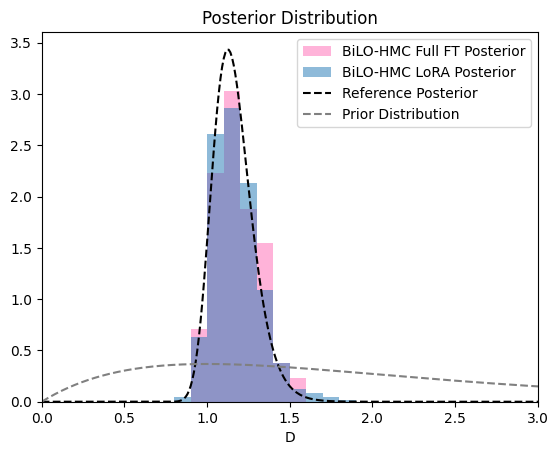

In [16]:
prior_D = prior(D_grid)

# histogram of bilo. theta_samples
plt.hist(D_samples_fullft, bins=np.arange(0, 6, 0.1), density=True, alpha=0.5, label='BiLO-HMC Full FT Posterior',color='#FF69B4')
plt.hist(D_samples_lora, bins=np.arange(0, 6, 0.1), density=True, alpha=0.5, label='BiLO-HMC LoRA Posterior',color='#1f77b4')
plt.plot(D_grid.numpy(), posterior.numpy(), label='Reference Posterior',linestyle='--',color='black')
plt.plot(D_grid.numpy(), prior_D.numpy(), label='Prior Distribution', linestyle='--', color='gray')
plt.xlabel('D')
plt.title('Posterior Distribution')
plt.xlim(0, 3)
plt.legend()

### Visualize the posterior distribution of the PDE solution

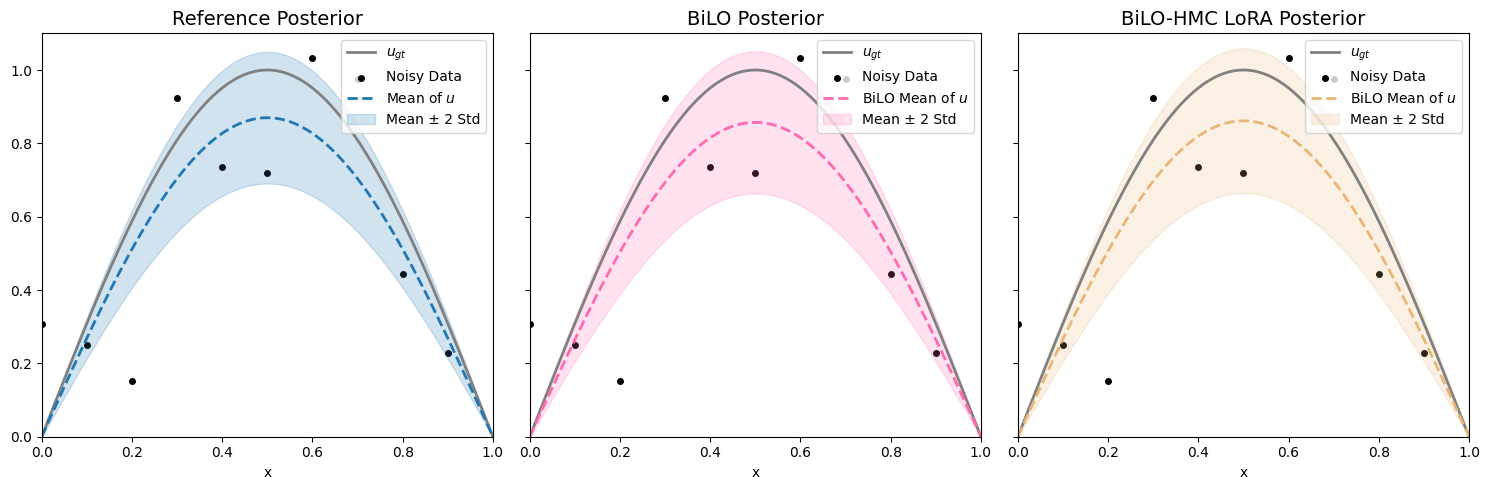

In [17]:
def plot_posterior(ax, x_test, u_gt, x_train, u_train, u_mean, u_std, color_mean, color_fill, title, label_mean):
    ax.plot(x_test, u_gt, color='gray', linewidth=2, label='$u_{gt}$')
    ax.scatter(x_train, u_train, color='black', s=16, label='Noisy Data')
    ax.plot(x_test, u_mean, linestyle='--', color=color_mean, linewidth=2, label=label_mean)
    ax.fill_between(
        x_test.view(-1).numpy(),
        (u_mean - 2 * u_std),
        (u_mean + 2 * u_std),
        color=color_fill, alpha=0.2, label='Mean ± 2 Std'
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('x')
    ax.legend(fontsize=10, loc='upper right')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

pde.to_device('cpu')

# Reference Posterior of u
plot_posterior(
    axs[0],
    pde.dataset['x_dat_test'],
    pde.u_exact(pde.dataset['x_dat_test'], D_gt),
    pde.dataset['x_dat_train'],
    pde.dataset['u_dat_train'],
    u_mean,
    u_std,
    color_mean='#1f77b4',
    color_fill='#1f77b4',
    title='Reference Posterior',
    label_mean='Mean of $u$'
)

# BiLO posterior of u (Full FT)
u_sample_fullft = np.concatenate(u_samples_fullft, axis=1)
u_mean_bilo_fullft = u_sample_fullft.mean(axis=1)
u_std_bilo_fullft = u_sample_fullft.std(axis=1)
plot_posterior(
    axs[1],
    pde.dataset['x_dat_test'],
    pde.u_exact(pde.dataset['x_dat_test'], D_gt),
    pde.dataset['x_dat_train'],
    pde.dataset['u_dat_train'],
    u_mean_bilo_fullft,
    u_std_bilo_fullft,
    color_mean='#FF69B4',
    color_fill='#FF69B4',
    title='BiLO Posterior',
    label_mean='BiLO Mean of $u$'
)

# BiLO posterior of u (LoRA)
u_sample_lora = np.concatenate(u_samples_lora, axis=1)
u_mean_bilo_lora = u_sample_lora.mean(axis=1)
u_std_bilo_lora = u_sample_lora.std(axis=1)
plot_posterior(
    axs[2],
    pde.dataset['x_dat_test'],
    pde.u_exact(pde.dataset['x_dat_test'], D_gt),
    pde.dataset['x_dat_train'],
    pde.dataset['u_dat_train'],
    u_mean_bilo_lora,
    u_std_bilo_lora,
    color_mean='#eab676',
    color_fill='#eab676',
    title='BiLO-HMC LoRA Posterior',
    label_mean='BiLO Mean of $u$'
)

plt.tight_layout()